In [7]:
import zipfile

zip_path = "archieve.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("dataset")


In [8]:
import os

for root, dirs, files in os.walk("dataset"):
    print(f"\n📂 Directory: {root}")
    print(f"📁 Subdirectories: {dirs}")
    print(f"📷 Files: {len(files)}")
    if files:
        print(f"🧾 Sample files: {files[:5]}")



📂 Directory: dataset
📁 Subdirectories: ['archieve']
📷 Files: 0

📂 Directory: dataset/archieve
📁 Subdirectories: ['animals']
📷 Files: 0

📂 Directory: dataset/archieve/animals
📁 Subdirectories: ['dog', 'cat']
📷 Files: 0

📂 Directory: dataset/archieve/animals/dog
📁 Subdirectories: []
📷 Files: 25
🧾 Sample files: ['00818-3846168980.png', '00811-3846168973.png', '00900-3846169062.png', '00895-3846169057.png', '00813-3846168975.png']

📂 Directory: dataset/archieve/animals/cat
📁 Subdirectories: []
📷 Files: 25
🧾 Sample files: ['00347-200124657.png', '00333-200124643.png', '00338-200124648.png', '00344-200124654.png', '00343-200124653.png']


In [9]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from tqdm import tqdm

In [12]:
# Paths
cat_dir = 'dataset/archieve/animals/cat'
dog_dir = 'dataset/archieve/animals/dog'


# Settings
image_size = 64  # Resize to 64x64
features = []
labels = []

# Load Cat Images
for filename in tqdm(os.listdir(cat_dir), desc='Loading Cats'):
    path = os.path.join(cat_dir, filename)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (image_size, image_size))
        features.append(img.flatten())
        labels.append(0)  # 0 = Cat

# Load Dog Images
for filename in tqdm(os.listdir(dog_dir), desc='Loading Dogs'):
    path = os.path.join(dog_dir, filename)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (image_size, image_size))
        features.append(img.flatten())
        labels.append(1)  # 1 = Dog

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

print(f"\n✅ Loaded {len(X)} images with shape {X[0].shape}")


Loading Dogs: 100%|██████████| 25/25 [00:00<00:00, 81.98it/s]


✅ Loaded 50 images with shape (4096,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [14]:
model = SVC(kernel='linear')
model.fit(X_train, y_train)


SVC(kernel='linear')

In [15]:
y_pred = model.predict(X_test)
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Cat", "Dog"]))



📊 Classification Report:

              precision    recall  f1-score   support

         Cat       0.67      0.80      0.73         5
         Dog       0.75      0.60      0.67         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10



In [16]:
from skimage.feature import hog
from skimage import color

def extract_hog_features(image_path, image_size=(128, 128)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, image_size)
    gray = color.rgb2gray(img)
    features, _ = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True
    )
    return features


In [17]:
features = []
labels = []

for filename in tqdm(os.listdir(cat_dir), desc='Cats (HOG)'):
    path = os.path.join(cat_dir, filename)
    try:
        feat = extract_hog_features(path)
        features.append(feat)
        labels.append(0)
    except:
        continue

for filename in tqdm(os.listdir(dog_dir), desc='Dogs (HOG)'):
    path = os.path.join(dog_dir, filename)
    try:
        feat = extract_hog_features(path)
        features.append(feat)
        labels.append(1)
    except:
        continue

X = np.array(features)
y = np.array(labels)


Dogs (HOG): 100%|██████████| 25/25 [00:01<00:00, 19.79it/s]


In [18]:
from sklearn.model_selection import GridSearchCV

params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']

}

grid = GridSearchCV(SVC(), params, cv=5)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)


Best params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [20]:
import joblib
joblib.dump(model, "svm_cat_dog_model.pkl")


['svm_cat_dog_model.pkl']

In [21]:
model = joblib.load("svm_cat_dog_model.pkl")


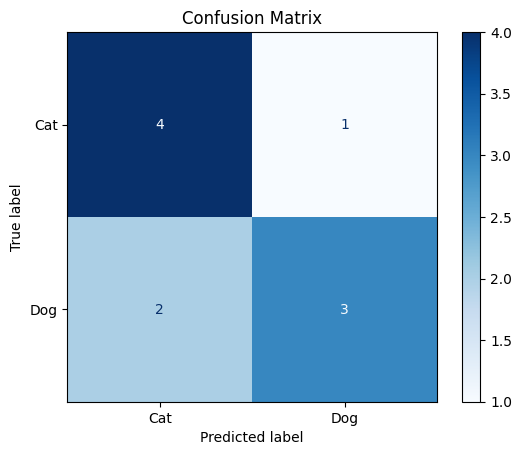

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Cat", "Dog"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


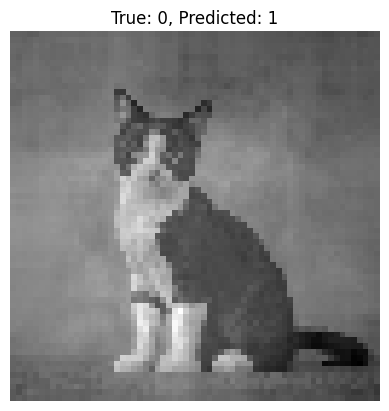

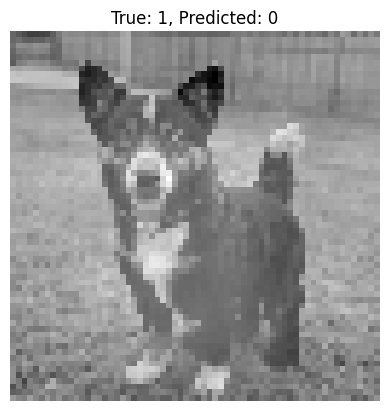

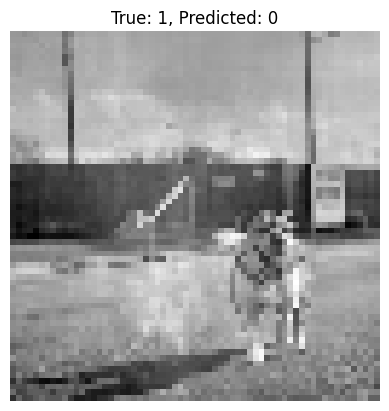

In [23]:
import matplotlib.pyplot as plt

X_test_raw = X_test  # Only works if you kept the original images (not just HOG)
wrong_idxs = np.where(y_pred != y_test)[0]

for idx in wrong_idxs[:5]:  # Show first 5 misclassified examples
    img = X_test_raw[idx].reshape(64, 64)  # Adjust shape if needed
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {y_test[idx]}, Predicted: {y_pred[idx]}")
    plt.axis('off')
    plt.show()
